In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [ ]:
import pandas as pd
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

In [ ]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map.
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/food-101/train'))
    # The following line was changed. 'meta' was replaced by 'test'
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)

# Method to recursively copy a directory.
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore.
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.
def load_images(path_to_imgs):
  resize_count = 0

  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)

  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files.
def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [ ]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    gen_train_test_split()
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/meta'))
    print(len_train,len_test)

train and test folders already exists.
29 6


In [ ]:
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


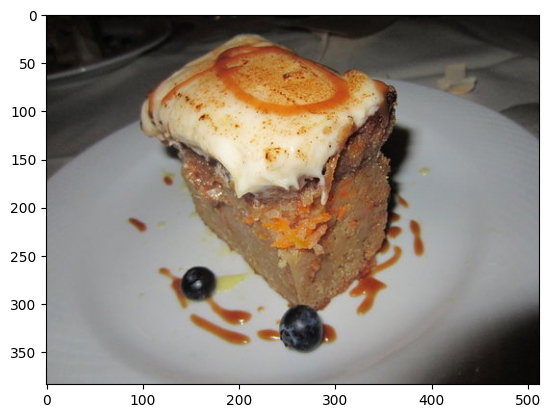

In [ ]:
testImg = imread('/content/food-101/images/carrot_cake/1069797.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [ ]:
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test
  X_train, y_train, X_test, y_test = load_train_test_data('/content/food-101/train','/content/food-101/test')

In [ ]:
tensorflow.keras.backend.clear_session()
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = '/content/food-101/train'
test_data = '/content/food-101/meta' # Changed test_data to point to the 'test' folder
train_samples = 75750
test_samples = 25250

if not os.path.isdir('./food-101/meta') and not os.path.isdir('./food-101/train'):

    gen_train_test_split()  # Assuming this function generates the train and test folders
    len_train = len(os.listdir('/content/food-101/train')) #removed an indent
    len_test = len(os.listdir('/content/food-101/test')) #removed an indent and changed to test folder
    print(len_train,len_test)
    train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.keras', save_best_only=True) # Added .keras extension to the filepath
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.keras')



Found 21427 images belonging to 29 classes.
Found 0 images belonging to 0 classes.
Epoch 1/30


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 29), output.shape=(None, 101)

# New Section